In [1]:
write = True # log this version as new
MODEL_DESCRIPTION = "Conditional Diffusion Full Dataset With Weighted Loss"

In [29]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from PIL import Image

import tensorflow as tf;
from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ReduceLROnPlateau

from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction

import pandas as pd
from sys import stdout
from datetime import datetime
import neptune as neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback
from astropy.io import fits
import random
from DataMakerPlus import *

In [30]:
%%capture
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

In [31]:
now = datetime.now()

DATASET_NAME = "HSC_v6"
MODEL_TYPE = "Conditional Diffusion"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/data3/Billy/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/data3/Billy/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/data3/Billy/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/data3/Billy/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/data3/Billy/Diffusion/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/data3/Billy/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/data3/Billy/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [32]:
channels = 5
BATCH_SIZE = 8

In [33]:
TRAIN_PATH = f'/data/HSC/HSC_v6/step3/5x127x127_training_max_2.hdf5'
# TEST_PATH = f'/data/HSC/HSC_v6/step3/5x127x127_testing_max_2.hdf5'

gen_args = {
    'image_key': 'image',
    'numerical_keys': None,
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}
train_gen = HDF5DataGenerator(TRAIN_PATH, mode = 'train', **gen_args)
# test_gen = HDF5DataGenerator(TEST_PATH, mode = 'train', **gen_args)
print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(8, 5, 127, 127)
(8,)


In [34]:
batch_count = 0
def next_batch():
    global batch_count
    x_train = np.asarray(np.transpose(train_gen[batch_count][0], (0, 2, 3, 1)))
    for i in range(len(x_train)):
        x_train[i] = np.true_divide(x_train[i], np.max(np.nan_to_num(x_train[i])))
    x_train = np.pad(x_train, [(0, 0), (0, 1), (0, 1), (0, 0)], mode = 'constant') # Padding to 128x128
    y_train = train_gen[batch_count][1]
    batch_count = batch_count + 1
    if batch_count == len(train_gen) - 1:
        batch_count = 0
    return x_train, y_train

In [43]:
timesteps = 200
max_noise = 0.1

# create a fixed beta schedule
beta = np.linspace(max_noise / timesteps, max_noise, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[ : -1]), axis = 0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1 - alpha_bar)

# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size = x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return tf.random.uniform(shape = [num], minval = 0, maxval = timesteps, dtype = tf.int32)

In [44]:
# Let us visualize the output image at a few timestamps
sample = next_batch()[0][0]

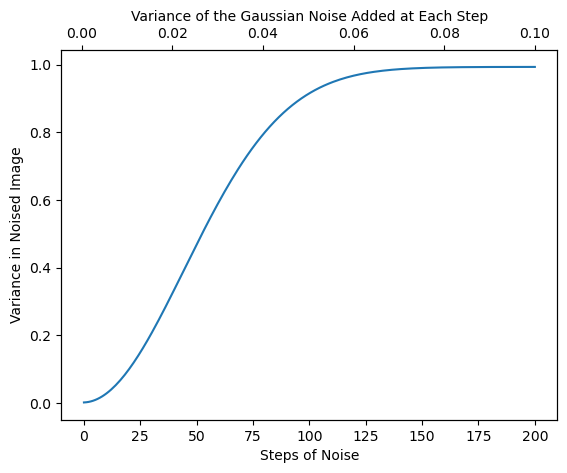

In [45]:
y_arr = np.array([])
for index, i in enumerate(range(timesteps)):
    noisy_im, noise = forward_noise(0, np.expand_dims(sample, 0), np.array([i, ]))
    y_arr = np.append(y_arr, np.var(noisy_im.flatten()))

x_arr = np.linspace(0, timesteps, timesteps)

fig, ax1 = plt.subplots()
ax1.plot(x_arr, y_arr)
ax1.set_xlabel("Steps of Noise")
ax1.set_ylabel("Variance in Noised Image")

ax2 = ax1.twiny()
ax2.plot(beta, 0 * np.ones(timesteps), alpha = 0) # Create a dummy plot
ax2.set_xlabel("Variance of the Gaussian Noise Added at Each Step")
plt.show()

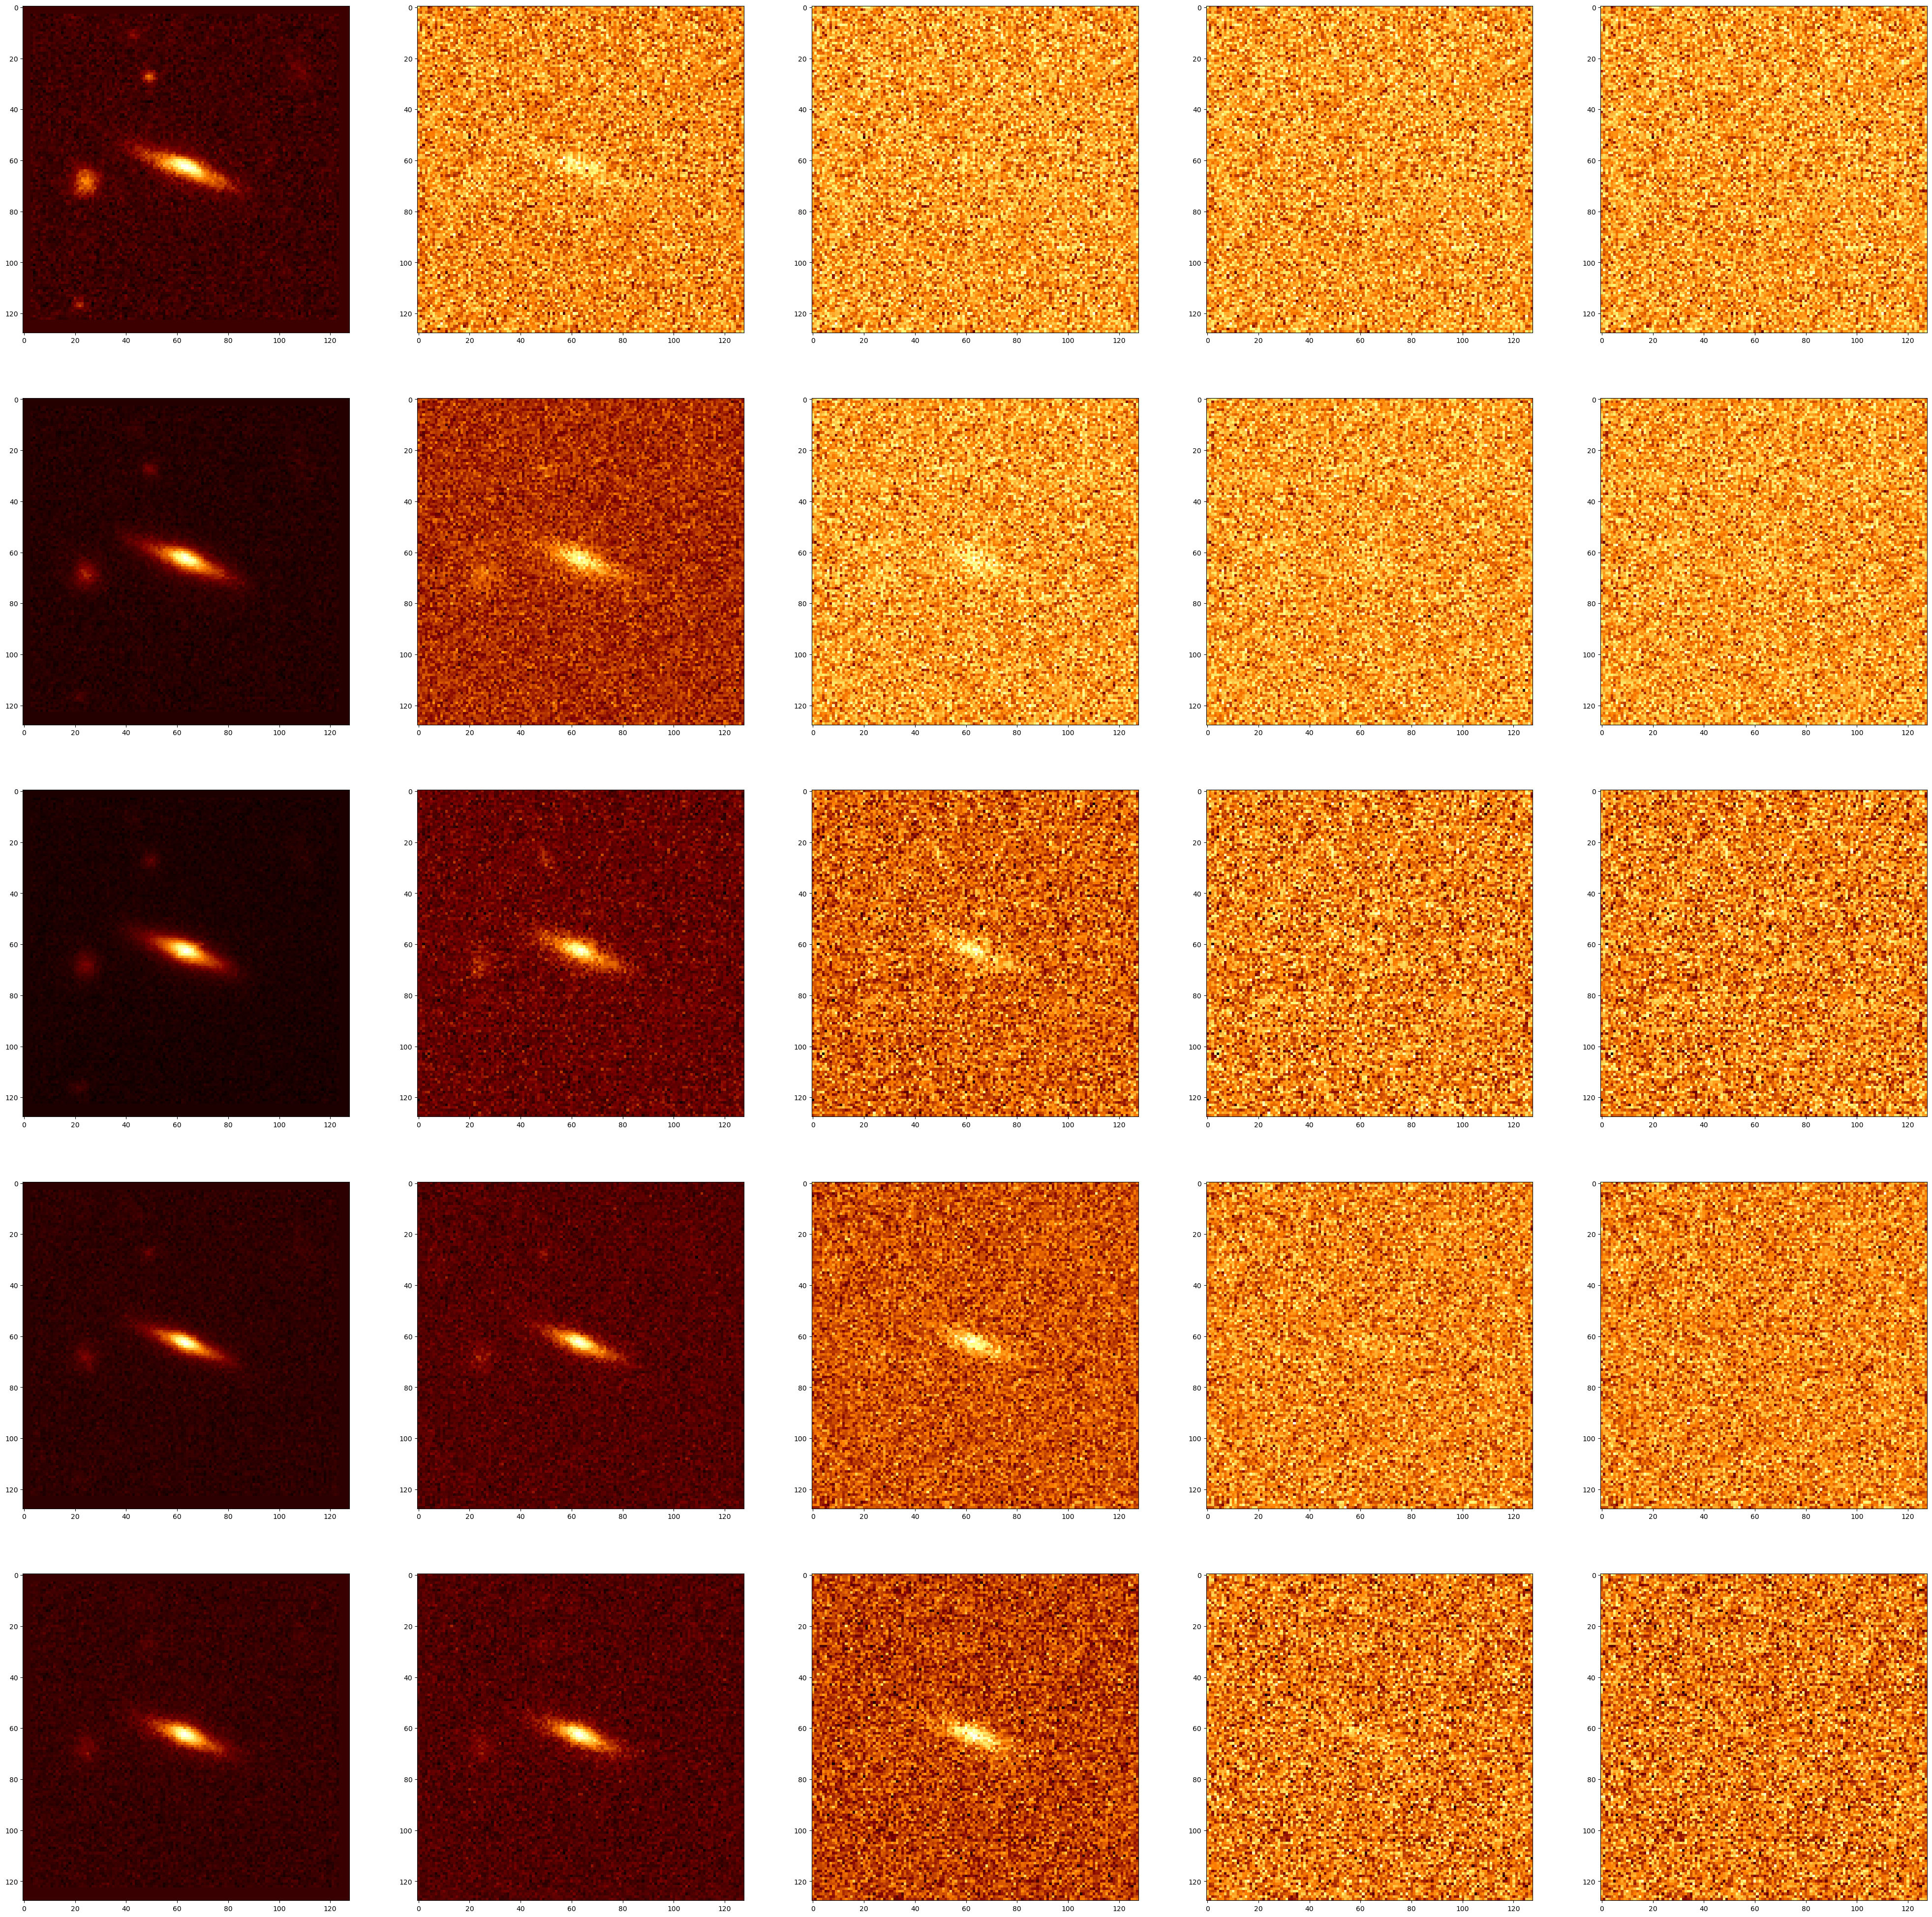

In [46]:
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (50, 50))

j = 0

for index, i in enumerate([0, 2, 10, 50, 150]):
    noisy_im, noise = forward_noise(0, np.expand_dims(sample, 0), np.array([i, ]))
    axes[0][j].imshow(noisy_im[0][:, :, 0], cmap = 'afmhot')
    axes[1][j].imshow(noisy_im[0][:, :, 1], cmap = 'afmhot')
    axes[2][j].imshow(noisy_im[0][:, :, 2], cmap = 'afmhot')
    axes[3][j].imshow(noisy_im[0][:, :, 3], cmap = 'afmhot')
    axes[4][j].imshow(noisy_im[0][:, :, 4], cmap = 'afmhot')
    j += 1
    

plt.show()

In [12]:
print("Data Initialization Complete!")

Data Initialization Complete!


In [13]:
# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# We will use this to convert timestamps to time encodings
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions = 10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training = True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype = tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis = -1)

        return emb
        
# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training = True):
        return tf.identity(x)


class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training = True):
        return self.fn(x, training = training) + x

def Upsample(dim):
    return nn.Conv2DTranspose(filters = dim, kernel_size = 4, strides = 2, padding = 'SAME')

def Downsample(dim):
    return nn.Conv2D(filters = dim, kernel_size = 4, strides = 2, padding = 'SAME')

class LayerNorm(Layer):
    def __init__(self, dim, eps = 1e-5, **kwargs):
        super(LayerNorm, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, 1, 1, dim]))
        self.b = tf.Variable(tf.zeros([1, 1, 1, dim]))

    def call(self, x, training = True):
        var = tf.math.reduce_variance(x, axis = -1, keepdims = True)
        mean = tf.reduce_mean(x, axis = -1, keepdims = True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def call(self, x, training = True):
        x = self.norm(x)
        return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training = True):
        return x * tf.nn.sigmoid(x)

def gelu(x, approximate = False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate = False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training = True):
        return gelu(x, self.approximate)

class MLP(Layer):
    def __init__(self, hidden_dim, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.net = Sequential([
            Rearrange('... -> ... 1'),  # expand_dims(axis=-1)
            nn.Dense(units=hidden_dim),
            GELU(),
            LayerNorm(hidden_dim),
            nn.Dense(units=hidden_dim),
            GELU(),
            LayerNorm(hidden_dim),
            nn.Dense(units=hidden_dim),
        ])

    def call(self, x, training=True):
        return self.net(x, training=training)


class ValueConditioning(Layer):  # Modify class name
    def __init__(self, res, num_channels = 5):
        super().__init__()
        self.block = Sequential([
            nn.Dense(res * res * num_channels),
            SiLU(),
            nn.Reshape((res, res, num_channels))
        ])

        self.block.compile()

    def call(self, x):  # Modify method signature
        return self.block(x)

In [14]:
# building block modules
class Block(Layer):
    def __init__(self, dim, groups = 8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size = 3, strides = 1, padding = 'SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon = 1e-05)
        self.act = SiLU()


    def call(self, x, gamma_beta = None, training = True):
        x = self.proj(x)
        x = self.norm(x, training=training)

        if exists(gamma_beta):
            gamma, beta = gamma_beta
            x = x * (gamma + 1) + beta

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim = None, groups = 8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units = dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups = groups)
        self.block2 = Block(dim_out, groups = groups)
        self.res_conv = nn.Conv2D(filters = dim_out, kernel_size = 1, strides = 1) if dim != dim_out else Identity()

    def call(self, x, time_emb = None, training = True):
        gamma_beta = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b 1 1 c')
            gamma_beta = tf.split(time_emb, num_or_size_splits = 2, axis = -1)

        h = self.block1(x, gamma_beta = gamma_beta, training = training)
        h = self.block2(h, training = training)

        return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads = 4, dim_head = 127):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters = self.hidden_dim * 3, kernel_size = 1, strides = 1, use_bias = False)

        self.to_out = Sequential([
            nn.Conv2D(filters = dim, kernel_size = 1, strides = 1),
            LayerNorm(dim)
        ])

    def call(self, x, training = True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits = 3, axis = -1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h = self.heads), qkv)

        q = tf.nn.softmax(q, axis = -2)
        k = tf.nn.softmax(k, axis = -1)

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h = self.heads, x = h, y = w)
        out = self.to_out(out, training = training)

        return out

class Attention(Layer):
    def __init__(self, dim, heads = 4, dim_head = 127):
        super(Attention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2D(filters = self.hidden_dim * 3, kernel_size = 1, strides = 1, use_bias = False)
        self.to_out = nn.Conv2D(filters = dim, kernel_size = 1, strides = 1)

    def call(self, x, training = True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits = 3, axis = -1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)
        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        sim_max = tf.stop_gradient(tf.expand_dims(tf.argmax(sim, axis = -1), axis = -1))
        sim_max = tf.cast(sim_max, tf.float32)
        sim = sim - sim_max
        attn = tf.nn.softmax(sim, axis = -1)

        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b x y (h d)', x = h, y = w)
        out = self.to_out(out, training = training)

        return out

In [15]:
class Unet_conditional(Model):
    def __init__(self,
                 dim = 128,
                 init_dim = None,
                 out_dim = None,
                 dim_mults = (1, 2, 4, 8),
                 channels = 5,
                 resnet_block_groups = 8,
                 learned_variance = False,
                 sinusoidal_cond_mlp = True,
                 class_embedder = None,
                 class_emb_dim = 64,
                 in_res = 128
                 ):
        super(Unet_conditional, self).__init__()

        # determine dimensions
        self.channels = channels
        self.in_res = in_res

        # self.class_embeddings = nn.Embedding(num_classes, class_emb_dim) if class_embedder is None else class_embedder

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)
        
        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp

        if sinusoidal_cond_mlp:
            self.time_mlp = Sequential([
                SinusoidalPosEmb(dim),
                nn.Dense(units=time_dim),
                GELU(),
                nn.Dense(units=time_dim)
            ], name="time embeddings")
        else:
            self.time_mlp = MLP(time_dim)

        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)

        now_res = in_res

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                ValueConditioning(now_res),
                block_klass(dim_in+1, dim_out, time_emb_dim=time_dim),
                block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])

            now_res //= 2 if not is_last else 1

        mid_dim = dims[-1]
        self.mid_conditioning = ValueConditioning(now_res)
        self.mid_block1 = block_klass(mid_dim+1, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                ValueConditioning(now_res),
                block_klass((dim_out * 2) + 1, dim_in, time_emb_dim=time_dim),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])

            now_res *= 2 if not is_last else 1

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_conv = Sequential([
            block_klass(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ], name="output")

    def call(self, x, time=None, condition_vector=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)

        # class_vector = self.class_embeddings(class_vector)
        
        h = []

        for conditioning, block1, block2, attn, downsample in self.downs:
            cv = conditioning(condition_vector)
            x = tf.concat([x, cv], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
        
        cv = self.mid_conditioning(condition_vector)
        x = tf.concat([x, cv], axis=-1)
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for conditioning, block1, block2, attn, upsample in self.ups:
            cv = conditioning(condition_vector)
            x = tf.concat([x, cv], axis=-1)
            x = tf.concat([x, h.pop()], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=-1)
        x = self.final_conv(x)
        return x

In [16]:
# create our unet model
unet = Unet_conditional(in_res = 128, channels = 5)

# initialize the model in the memory of our GPU
test_images = np.ones([1, 128, 128, channels])
test_timestamps = generate_timestamp(0, 1)
test_condition = np.array([[1]])
k = unet(test_images, test_timestamps, test_condition)

# create our optimizer, we will use adam with a Learning rate of 1e-4
opt = keras.optimizers.Adam(learning_rate = 1e-4)

2023-07-20 00:25:56.435508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-20 00:25:56.900233: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-20 00:25:57.061117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [17]:
unet.summary()

Model: "unet_conditional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  20664     
                                                                 
 time embeddings (Sequential  (1, 512)                 328704    
 )                                                               
                                                                 
 value_conditioning (ValueCo  multiple                 163840    
 nditioning)                                                     
                                                                 
 resnet_block (ResnetBlock)  multiple                  393600    
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 427008    
 )                                                               
                                                  

In [18]:
def loss_fn(real, generated, condition):
    loss = tf.reduce_mean((real - generated) ** 2)
    return loss

In [19]:
print("Network Initialization Complete!")

Network Initialization Complete!


In [20]:
def train_step(batch, condition):
    rng, tsrng = np.random.randint(0, 100000, size=(2,))
    timestep_values = generate_timestamp(tsrng, batch.shape[0])

    noised_image, noise = forward_noise(rng, batch, tf.cast(timestep_values, tf.int32))
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values, condition)
        
        loss_value = loss_fn(noise, prediction, condition)
    
    gradients = tape.gradient(loss_value, unet.trainable_variables)
    opt.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

epochs = 3

opt.learning_rate = 1e-5

for e in range(1, epochs + 1):
    bar = tf.keras.utils.Progbar(len(train_gen))
    losses = []
    for i in range(0, len(train_gen)):
        batch, condition = next_batch()
        loss = train_step(batch, condition)
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])  

    avg = np.mean(losses)
    if e > 2:
        opt.learning_rate = 1e-6
    print(f"Average loss for epoch {e}/{epochs}: {avg}")

2023-07-20 00:26:03.574404: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x89720460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-20 00:26:03.574430: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-07-20 00:26:03.577720: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-20 00:26:03.630051: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-20 00:26:03.675010: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23838/23839 [============================>.] - ETA: 0s - loss: 0.0201Average loss for epoch 3/3: 0.02008344978094101


In [21]:
unet.save_weights('/data3/Billy/unnormalized_weights_full_quadratic_weighted_5.csv')

In [22]:
unet.load_weights('/data3/Billy/unnormalized_weights_full_quadratic_weighted_5.csv')

In [23]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [24]:
def save_gif(img_list, path = "", interval = 200):
    # Transform images from [-1,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = np.array(im)
        max = np.amax(np.nan_to_num(img_list))
        min = np.amin(np.nan_to_num(img_list))
        im = (im - min) / (max - min) * 255
        im = np.clip(im, 0, 255).astype(np.int32)
        im = Image.fromarray(im)
        imgs.append(im)
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp = path, format='GIF', append_images = imgs,
             save_all = True, duration = interval, loop = 0)

In [25]:
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

In [26]:
for k in range(0, 5):
    z = k / 2 + 0.1
    x = tf.random.normal((1, 128, 128, 5))

    img_list_g = []
    img_list_r = []
    img_list_i = []
    img_list_z = []
    img_list_y = []
    img_list_g.append(np.squeeze(x, 0)[: , : , 0])
    img_list_r.append(np.squeeze(x, 0)[: , : , 1])
    img_list_i.append(np.squeeze(x, 0)[: , : , 2])
    img_list_z.append(np.squeeze(x, 0)[: , : , 3])
    img_list_y.append(np.squeeze(x, 0)[: , : , 4])
    
    for i in tqdm(range(timesteps - 1)):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, np.array([z]), t)
        x = ddpm(x, pred_noise, t)
        img_list_g.append(np.squeeze(x, 0)[: , : , 0])
        img_list_r.append(np.squeeze(x, 0)[: , : , 1])
        img_list_i.append(np.squeeze(x, 0)[: , : , 2])
        img_list_z.append(np.squeeze(x, 0)[: , : , 3])
        img_list_y.append(np.squeeze(x, 0)[: , : , 4])
            

    save_gif(img_list_g + ([img_list_g[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_g.gif", interval = 20)
    save_gif(img_list_r + ([img_list_r[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_r.gif", interval = 20)
    save_gif(img_list_i + ([img_list_i[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_i.gif", interval = 20)
    save_gif(img_list_z + ([img_list_z[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_z.gif", interval = 20)
    save_gif(img_list_y + ([img_list_y[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_y.gif", interval = 20)

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


In [27]:
z = random.uniform(0, 4)

x = tf.random.normal((1, 128, 128, 5))

for i in tqdm(range(timesteps - 1)):
    
    t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
    pred_noise = unet(x, np.array([z]), t)
    x = ddpm(x, pred_noise, t)
    
image_g = np.squeeze(x, 0)[: , : , 0][:-1, :-1]
image_r = np.squeeze(x, 0)[: , : , 1][:-1, :-1]
image_i = np.squeeze(x, 0)[: , : , 2][:-1, :-1]
image_z = np.squeeze(x, 0)[: , : , 3][:-1, :-1]
image_y = np.squeeze(x, 0)[: , : , 4][:-1, :-1]

five_band_image = np.array([image_g, image_r, image_i, image_z, image_y])
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])

hf = h5py.File('/data3/Diffusion/127x127_diffusion_generated_7.hdf5', 'a')
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [z], chunks = True, maxshape = (None, ))

for i in range(1999):
    
    stdout.write("\rChecking %d samples of " % (i + 1) + "2000")
    
    z = random.uniform(0, 4)
    
    x = tf.random.normal((1, 128, 128, 5))
    
    for i in tqdm(range(timesteps - 1)):
        
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, np.array([z]), t)
        x = ddpm(x, pred_noise, t)
    
    image_g = np.squeeze(x, 0)[: , : , 0][:-1, :-1]
    image_r = np.squeeze(x, 0)[: , : , 1][:-1, :-1]
    image_i = np.squeeze(x, 0)[: , : , 2][:-1, :-1]
    image_z = np.squeeze(x, 0)[: , : , 3][:-1, :-1]
    image_y = np.squeeze(x, 0)[: , : , 4][:-1, :-1]
    
    five_band_image = np.array([image_g, image_r, image_i, image_z, image_y])
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image

hf.close()

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 2 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 3 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 4 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 5 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 6 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 7 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Checking 8 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 9 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 10 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 11 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 12 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 13 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 14 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 15 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 16 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 17 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 18 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 19 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 20 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 21 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 22 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 23 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.47it/s]


Checking 24 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 25 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 26 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 27 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 28 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 29 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 30 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 31 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.43it/s]


Checking 32 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.35it/s]


Checking 33 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 34 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.47it/s]


Checking 35 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.42it/s]


Checking 36 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.47it/s]


Checking 37 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.49it/s]


Checking 38 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.41it/s]


Checking 39 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.44it/s]


Checking 40 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 41 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.43it/s]


Checking 42 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Checking 43 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.40it/s]


Checking 44 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Checking 45 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.43it/s]


Checking 46 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.43it/s]


Checking 47 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 48 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 49 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 50 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 51 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 52 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 53 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 54 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 55 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.52it/s]


Checking 56 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 57 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 58 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 59 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 60 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 61 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 62 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 63 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 64 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 65 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 66 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 67 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 68 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 69 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.41it/s]


Checking 70 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 71 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 72 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 73 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 74 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 75 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 76 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 77 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 78 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 79 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 80 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 81 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 82 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 83 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 84 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 85 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.48it/s]


Checking 86 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.35it/s]


Checking 87 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.36it/s]


Checking 88 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 89 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 90 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 91 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.46it/s]


Checking 92 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 93 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 94 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.48it/s]


Checking 95 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 96 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 97 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 98 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.52it/s]


Checking 99 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 100 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 101 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 102 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 103 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 104 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 105 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 106 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 107 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 108 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 109 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 110 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 111 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.46it/s]


Checking 112 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 113 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Checking 114 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 115 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 116 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 117 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 118 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 119 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 120 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 121 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 122 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 123 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 124 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 125 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 126 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 127 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 128 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 129 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 130 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Checking 131 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 132 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 133 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 134 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 135 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.38it/s]


Checking 136 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.47it/s]


Checking 137 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 138 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.49it/s]


Checking 139 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 140 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 141 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 142 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 143 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 144 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.43it/s]


Checking 145 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 146 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 147 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 148 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 149 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 150 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 151 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 152 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 153 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.52it/s]


Checking 154 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 155 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 156 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 157 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 158 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 159 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 160 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 161 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 162 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 163 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 164 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 165 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 166 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 167 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 168 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 169 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 170 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 171 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 172 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.85it/s]


Checking 173 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 174 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 175 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 176 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 177 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 178 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 179 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 180 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 181 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 182 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 183 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 184 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 185 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 186 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 187 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 188 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 189 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 190 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 191 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 192 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 193 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 194 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 195 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 196 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 197 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 198 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 199 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 200 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 201 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 202 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 203 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 204 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 205 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 206 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 207 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 208 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 209 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 210 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 211 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 212 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 213 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 214 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 215 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 216 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 217 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.91it/s]


Checking 218 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.84it/s]


Checking 219 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.93it/s]


Checking 220 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.89it/s]


Checking 221 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 222 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 223 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.84it/s]


Checking 224 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 225 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 226 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 227 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 228 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 229 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 230 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 231 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 232 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 233 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 234 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 235 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 236 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 237 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 238 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 239 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 240 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 241 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 242 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 243 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 244 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 245 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.81it/s]


Checking 246 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 247 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 248 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 249 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 250 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 251 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 252 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 253 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 254 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 255 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 256 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 257 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 258 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 259 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 260 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 261 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 262 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 263 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 264 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 265 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 266 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 267 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 268 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.84it/s]


Checking 269 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 270 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 271 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 272 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 273 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 274 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 275 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 276 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 277 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 278 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 279 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 280 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 281 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 282 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 283 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 284 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 285 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 286 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 287 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 288 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 289 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 290 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 291 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 292 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 293 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 294 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 295 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 296 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.89it/s]


Checking 297 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 298 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 299 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 300 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 301 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.91it/s]


Checking 302 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.86it/s]


Checking 303 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 304 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 305 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 306 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 307 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 308 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 309 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 310 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 311 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 312 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 313 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 314 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 315 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 316 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 317 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.81it/s]


Checking 318 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 319 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 320 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 321 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 322 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 323 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 324 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 325 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 326 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 327 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 328 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 329 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 330 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 331 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 332 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 333 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 334 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.83it/s]


Checking 335 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 336 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 337 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 338 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 339 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 340 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 341 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 342 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 343 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 344 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 345 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 346 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 347 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 348 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 349 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 350 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 351 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 352 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 353 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 354 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 355 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 356 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.86it/s]


Checking 357 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 358 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 359 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 360 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 361 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 362 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 363 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 364 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 365 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 366 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 367 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 368 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 369 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 370 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.83it/s]


Checking 371 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 372 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 373 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 374 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 375 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 376 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 377 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 378 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 379 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 380 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 381 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 382 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 383 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 384 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 385 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 386 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 387 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 388 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 389 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 390 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 391 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 392 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 393 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 394 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 395 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 396 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 397 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 398 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 399 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 400 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 401 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 402 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 403 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 404 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 405 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 406 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.86it/s]


Checking 407 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 408 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 409 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 410 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 411 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 412 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 413 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Checking 414 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 415 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 416 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 417 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 418 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.86it/s]


Checking 419 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 420 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 421 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 422 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 423 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 424 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 425 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 426 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 427 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 428 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 429 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 430 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 431 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 432 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 433 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 434 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 435 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 436 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 437 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 438 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.81it/s]


Checking 439 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.81it/s]


Checking 440 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 441 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 442 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 443 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 444 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 445 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 446 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 447 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 448 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 449 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 450 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 451 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 452 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 453 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 454 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 455 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 456 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 457 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.84it/s]


Checking 458 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 459 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 460 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.89it/s]


Checking 461 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 462 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 463 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 464 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 465 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 466 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 467 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 468 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 469 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 470 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 471 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 472 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 473 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 474 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 475 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 476 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 477 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 478 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 479 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 480 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 481 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 482 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 483 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 484 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 485 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 486 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 487 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 488 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 489 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 490 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 491 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 492 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 493 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 494 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 495 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 496 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 497 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 498 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 499 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 500 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 501 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 502 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 503 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 504 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 505 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 506 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 507 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 508 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 509 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 510 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 511 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 512 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 513 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 514 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 515 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 516 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 517 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 518 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 519 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 520 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 521 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 522 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 523 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 524 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 525 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 526 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 527 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 528 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 529 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 530 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 531 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 532 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 533 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 534 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 535 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 536 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 537 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 538 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 539 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 540 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 541 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 542 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 543 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 544 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 545 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 546 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 547 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 548 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 549 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 550 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 551 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 552 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 553 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 554 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 555 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 556 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 557 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 558 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 559 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 560 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 561 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 562 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 563 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 564 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 565 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 566 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 567 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 568 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 569 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 570 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 571 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 572 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 573 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 574 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 575 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 576 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 577 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 578 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 579 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 580 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 581 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 582 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 583 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 584 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 585 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.96it/s]


Checking 586 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.84it/s]


Checking 587 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 588 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 589 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 590 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 591 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 592 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 593 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 594 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 595 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 596 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 597 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 598 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.52it/s]


Checking 599 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 600 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 601 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.81it/s]


Checking 602 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 603 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 604 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 605 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 606 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 607 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 608 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 609 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 610 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 611 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 612 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 613 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 614 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 615 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 616 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 617 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 618 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 619 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 620 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 621 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 622 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 623 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 624 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 625 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 626 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 627 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 628 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.81it/s]


Checking 629 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 630 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 631 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 632 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 633 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 634 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 635 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 636 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 637 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 638 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 639 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 640 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 641 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 642 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 643 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 644 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 645 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 646 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.52it/s]


Checking 647 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 648 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 649 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 650 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 651 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 652 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 653 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 654 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Checking 655 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.46it/s]


Checking 656 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 657 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 658 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 659 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 660 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 661 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 662 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.52it/s]


Checking 663 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 664 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 665 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 666 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.46it/s]


Checking 667 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 668 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 669 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Checking 670 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.48it/s]


Checking 671 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 672 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 673 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 674 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 675 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 676 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 677 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 678 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 679 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 680 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 681 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 682 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 683 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 684 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 685 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 686 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 687 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 688 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 689 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 690 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 691 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 692 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 693 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 694 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 695 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 696 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 697 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 698 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 699 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 700 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 701 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 702 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 703 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 704 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 705 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 706 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 707 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 708 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 709 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 710 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 711 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 712 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 713 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 714 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 715 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 716 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 717 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 718 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 719 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 720 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 721 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 722 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 723 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 724 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 725 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 726 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 727 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 728 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 729 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 730 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 731 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 732 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 733 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 734 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 735 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 736 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 737 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 738 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 739 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 740 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 741 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 742 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.85it/s]


Checking 743 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.85it/s]


Checking 744 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.81it/s]


Checking 745 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 746 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 747 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 748 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 749 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 750 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 751 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 752 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 753 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 754 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 755 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 756 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 757 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 758 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 759 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 760 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 761 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 762 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 763 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 764 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 765 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 766 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 767 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 768 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 769 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 770 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 771 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 772 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 773 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 774 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 775 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 776 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 777 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 778 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.83it/s]


Checking 779 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 780 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 781 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 782 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 783 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 784 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 785 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 786 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 787 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 788 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 789 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 790 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 791 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 792 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 793 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 794 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 795 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 796 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 797 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 798 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 799 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 800 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 801 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 802 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 803 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 804 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 805 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 806 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 807 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 808 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 809 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 810 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 811 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 812 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 813 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 814 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 815 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 816 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 817 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.41it/s]


Checking 818 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 819 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 820 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 821 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 822 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 823 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 824 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 825 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 826 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 827 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 828 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.52it/s]


Checking 829 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 830 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 831 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 832 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 833 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 834 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 835 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 836 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 837 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 838 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.85it/s]


Checking 839 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 840 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.81it/s]


Checking 841 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 842 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 843 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 844 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 845 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 846 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 847 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 848 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 849 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 850 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 851 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 852 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 853 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 854 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 855 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 856 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 857 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.52it/s]


Checking 858 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.44it/s]


Checking 859 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.49it/s]


Checking 860 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 861 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Checking 862 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 863 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.41it/s]


Checking 864 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.47it/s]


Checking 865 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 866 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Checking 867 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 868 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 869 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.46it/s]


Checking 870 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.40it/s]


Checking 871 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 872 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.46it/s]


Checking 873 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.45it/s]


Checking 874 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 875 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 876 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 877 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 878 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 879 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.84it/s]


Checking 880 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 881 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 882 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 883 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 884 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 885 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 886 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 887 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 888 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 889 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 890 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 891 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.84it/s]


Checking 892 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.52it/s]


Checking 893 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 894 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 895 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 896 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 897 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 898 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 899 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 900 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 901 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 902 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 903 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 904 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 905 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 906 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 907 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 908 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 909 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 910 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 911 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 912 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 913 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 914 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 915 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 916 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 917 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 918 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 919 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 920 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 921 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 922 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 923 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 924 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 925 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 926 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 927 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 928 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 929 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 930 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 931 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 932 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 933 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 934 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 935 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 936 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 937 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 938 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 939 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 940 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 941 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 942 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 943 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 944 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 945 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 946 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 947 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 948 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 949 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 950 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 951 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 952 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 953 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 954 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 955 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 956 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 957 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 958 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 959 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 960 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 961 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 962 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 963 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 964 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 965 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 966 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 967 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 968 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 969 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 970 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 971 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 972 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 973 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 974 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 975 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 976 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.89it/s]


Checking 977 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 978 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 979 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 980 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 981 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 982 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 983 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 984 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 985 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 986 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 987 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 988 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 989 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 990 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.43it/s]


Checking 991 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.52it/s]


Checking 992 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 993 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 994 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 995 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 996 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 997 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 998 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 999 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 1000 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1001 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1002 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1003 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1004 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1005 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1006 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 1007 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1008 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1009 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 1010 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1011 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1012 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1013 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1014 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1015 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 1016 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1017 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1018 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1019 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 1020 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1021 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1022 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1023 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 1024 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1025 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 1026 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1027 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1028 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1029 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1030 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 1031 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 1032 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1033 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1034 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1035 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1036 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1037 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1038 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 1039 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1040 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1041 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1042 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 1043 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1044 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1045 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1046 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1047 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 1048 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1049 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1050 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1051 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1052 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1053 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 1054 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1055 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1056 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1057 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 1058 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 1059 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1060 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1061 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1062 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1063 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1064 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1065 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1066 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1067 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 1068 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 1069 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1070 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 1071 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1072 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1073 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1074 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1075 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1076 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1077 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1078 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 1079 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 1080 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 1081 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.84it/s]


Checking 1082 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1083 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1084 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1085 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 1086 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1087 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1088 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1089 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 1090 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1091 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1092 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1093 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1094 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1095 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1096 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1097 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1098 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1099 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1100 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1101 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1102 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1103 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1104 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1105 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1106 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1107 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1108 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1109 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1110 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1111 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 1112 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1113 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1114 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1115 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1116 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1117 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1118 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1119 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1120 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1121 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1122 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1123 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 1124 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1125 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 1126 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1127 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1128 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 1129 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1130 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1131 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1132 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1133 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1134 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1135 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1136 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 1137 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1138 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1139 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1140 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1141 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1142 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1143 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1144 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1145 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1146 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1147 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.87it/s]


Checking 1148 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 1149 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 1150 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 1151 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1152 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1153 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1154 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 1155 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1156 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1157 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1158 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1159 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 1160 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 1161 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1162 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1163 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1164 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1165 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1166 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1167 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1168 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1169 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1170 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1171 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1172 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1173 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1174 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1175 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1176 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 1177 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1178 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1179 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1180 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1181 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1182 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1183 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1184 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1185 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1186 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1187 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1188 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1189 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 1190 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 1191 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1192 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 1193 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1194 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1195 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 1196 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1197 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1198 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1199 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1200 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1201 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1202 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1203 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 1204 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1205 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1206 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 1207 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1208 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1209 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1210 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1211 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1212 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1213 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1214 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1215 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1216 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1217 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1218 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1219 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1220 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1221 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 1222 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 1223 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 1224 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 1225 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1226 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1227 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 1228 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1229 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1230 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1231 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1232 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1233 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1234 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1235 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1236 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1237 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 1238 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1239 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1240 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.83it/s]


Checking 1241 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.83it/s]


Checking 1242 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 1243 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1244 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1245 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1246 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1247 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1248 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1249 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.49it/s]


Checking 1250 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Checking 1251 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1252 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1253 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1254 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 1255 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 1256 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1257 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 1258 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1259 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1260 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1261 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1262 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1263 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 1264 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1265 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.53it/s]


Checking 1266 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.47it/s]


Checking 1267 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1268 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1269 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1270 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1271 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1272 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1273 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1274 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1275 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1276 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1277 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1278 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1279 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1280 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1281 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 1282 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1283 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 1284 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1285 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1286 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1287 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1288 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1289 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1290 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.54it/s]


Checking 1291 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1292 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1293 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1294 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1295 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1296 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1297 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1298 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1299 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1300 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1301 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1302 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1303 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1304 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.81it/s]


Checking 1305 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1306 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1307 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 1308 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1309 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1310 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1311 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1312 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1313 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1314 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1315 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1316 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1317 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1318 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1319 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1320 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1321 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 1322 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1323 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 1324 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 1325 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1326 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.50it/s]


Checking 1327 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1328 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1329 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1330 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1331 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1332 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1333 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.83it/s]


Checking 1334 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1335 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1336 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1337 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.58it/s]


Checking 1338 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1339 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1340 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 1341 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1342 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 1343 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 1344 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1345 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1346 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1347 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 1348 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1349 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1350 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1351 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1352 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1353 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1354 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.52it/s]


Checking 1355 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1356 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1357 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1358 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1359 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1360 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 1361 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 1362 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 1363 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1364 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1365 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1366 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1367 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1368 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1369 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1370 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1371 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1372 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1373 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1374 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1375 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1376 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1377 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1378 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1379 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1380 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1381 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1382 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1383 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1384 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 1385 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1386 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1387 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1388 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.85it/s]


Checking 1389 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1390 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1391 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1392 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1393 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1394 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1395 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1396 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1397 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1398 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.60it/s]


Checking 1399 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1400 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 1401 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1402 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1403 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1404 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.51it/s]


Checking 1405 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1406 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1407 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1408 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]


Checking 1409 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.55it/s]


Checking 1410 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1411 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1412 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1413 samples of 2000

100%|██████████| 199/199 [00:33<00:00,  5.98it/s]


Checking 1414 samples of 2000

100%|██████████| 199/199 [00:32<00:00,  6.15it/s]


Checking 1415 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.31it/s]


Checking 1416 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.38it/s]


Checking 1417 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.35it/s]


Checking 1418 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.47it/s]


Checking 1419 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.36it/s]


Checking 1420 samples of 2000

100%|██████████| 199/199 [00:32<00:00,  6.10it/s]


Checking 1421 samples of 2000

100%|██████████| 199/199 [00:32<00:00,  6.20it/s]


Checking 1422 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.29it/s]


Checking 1423 samples of 2000

100%|██████████| 199/199 [00:32<00:00,  6.08it/s]


Checking 1424 samples of 2000

100%|██████████| 199/199 [00:32<00:00,  6.04it/s]


Checking 1425 samples of 2000

100%|██████████| 199/199 [00:31<00:00,  6.33it/s]


Checking 1426 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.56it/s]


Checking 1427 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1428 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1429 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1430 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1431 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 1432 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1433 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1434 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 1435 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1436 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1437 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1438 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 1439 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 1440 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.61it/s]


Checking 1441 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 1442 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.87it/s]


Checking 1443 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 1444 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1445 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1446 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 1447 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1448 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1449 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1450 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 1451 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1452 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 1453 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1454 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1455 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 1456 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 1457 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1458 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1459 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1460 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1461 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1462 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1463 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1464 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.59it/s]


Checking 1465 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 1466 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 1467 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1468 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.85it/s]


Checking 1469 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1470 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.63it/s]


Checking 1471 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.78it/s]


Checking 1472 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1473 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.75it/s]


Checking 1474 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.71it/s]


Checking 1475 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1476 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.73it/s]


Checking 1477 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1478 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Checking 1479 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1480 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.68it/s]


Checking 1481 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.67it/s]


Checking 1482 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1483 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.85it/s]


Checking 1484 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 1485 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 1486 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 1487 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.72it/s]


Checking 1488 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.70it/s]


Checking 1489 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.65it/s]


Checking 1490 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.76it/s]


Checking 1491 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 1492 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.77it/s]


Checking 1493 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.80it/s]


Checking 1494 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.62it/s]


Checking 1495 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1496 samples of 2000

100%|██████████| 199/199 [00:30<00:00,  6.63it/s]


Checking 1497 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.74it/s]


Checking 1498 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.64it/s]


Checking 1499 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.69it/s]


Checking 1500 samples of 2000

100%|██████████| 199/199 [00:28<00:00,  6.87it/s]


Checking 1501 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.82it/s]


Checking 1502 samples of 2000

100%|██████████| 199/199 [00:29<00:00,  6.79it/s]


Checking 1503 samples of 2000

 74%|███████▍  | 148/199 [00:21<00:07,  6.76it/s]


KeyboardInterrupt: 

In [28]:
hf.close()

In [ ]:
print("Data Generation Complete!")

In [ ]:
# END